<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/heatmaps.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples/heatmaps.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples/heatmaps.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples/heatmaps.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


# <span style="color: orange">**FiftyOne Heatmaps**

## Learning how to use heatmaps in FiftyOne and a pose estimation example

### A basic heatmap

In [1]:
import cv2
import numpy as np

import fiftyone as fo

# Example heatmap
map_path = "/tmp/heatmap.png"
map = np.random.randint(256, size=(128, 128), dtype=np.uint8)
cv2.imwrite(map_path, map)

sample = fo.Sample(filepath="/path/to/image.png")
sample["heatmap1"] = fo.Heatmap(map_path=map_path)
sample["heatmap2"] = fo.Heatmap(map=map)

print(sample)

<Sample: {
    'id': None,
    'media_type': 'image',
    'filepath': '/path/to/image.png',
    'tags': [],
    'metadata': None,
    'heatmap1': <Heatmap: {
        'id': '651c2983ba6f926495470215',
        'tags': [],
        'map': None,
        'map_path': '/tmp/heatmap.png',
        'range': None,
    }>,
    'heatmap2': <Heatmap: {
        'id': '651c2983ba6f926495470216',
        'tags': [],
        'map': array([[160, 101, 116, ..., 242, 248,  84],
               [118,  56, 208, ..., 221, 210,  70],
               [ 49, 228, 245, ..., 111,  19, 139],
               ...,
               [ 88, 155, 104, ...,   8, 179, 127],
               [ 31, 152,  90, ..., 239, 220, 149],
               [ 33, 243,  64, ..., 185, 199,  81]], dtype=uint8),
        'map_path': None,
        'range': None,
    }>,
}>


## Setting up [SWAHR-HumanPose](https://github.com/greatlog/SWAHR-HumanPose/tree/master) Model

It is highly suggested that you use an venv such as conda to set up a seperate enviroment for the following. Refer to [this README](https://github.com/HRNet/HigherHRNet-Human-Pose-Estimation/blob/master/README.md) for trouble shooting

In [ ]:
!git clone https://github.com/greatlog/SWAHR-HumanPose.git

Download the model linked [here](https://drive.google.com/drive/folders/13FFvwK7bDZLD4H_toueopbLhJqFjimlu), I used pose_higher_hrnet_w32_512.pth, make sure to place in the ./models dir in the SWAHR repo

In [ ]:
# COCOAPI=/path/to/clone/cocoapi
!git clone https://github.com/cocodataset/cocoapi.git $COCOAPI
!cd $COCOAPI/PythonAPI
# Install into global site-packages
!make install
# Alternatively, if you do not have permissions or prefer
# not to install the COCO API into global site-packages
!python3 setup.py install --user

In [ ]:
# CROWDPOSE=/path/to/clone/crowdpose
!git clone https://github.com/Jeff-sjtu/CrowdPose.git $CROWDPOSE
!cd $CROWDPOSE/PythonAPI
# Install into global site-packages
!make install
# Alternatively, if you do not have permissions or prefer
# not to install the CROWDPOSE API into global site-packages
!python3 setup.py install --user


Finally you may need to roll back some packages, namely numpy

In [ ]:
!pip3 install numpy==1.20.0

## Generating Heatmaps

We will use the [tools/dist_inference.py](https://github.com/greatlog/SWAHR-HumanPose/blob/master/tools/dist_inference.py) script to generate our heatmaps

### File changes

Make these changes to the appropriate files:

In [10]:
#Line 42 in tools/dist_inference.py add make_heatmaps
from utils.vis import draw_skeleton, make_heatmaps

In [ ]:
#Line 196 in tools/dist_inference.py add the following block
            images,heatmaps = make_heatmaps(image,final_heatmaps[0])
            master_heatmap = heatmaps[0]
            for x in heatmaps:
                master_heatmap = np.maximum(master_heatmap, x)
            resized_m_heatmap = cv2.resize(master_heatmap,(image.shape[1],image.shape[0]))
            cv2.imwrite(
                    os.path.join(save_dir, "{}_heatmap.png".format(image_name)),
                    resized_m_heatmap
                    )

In [ ]:
#Line 84 in lib/utils/vis.py add a extra return variable heatmaps
return image_grid, heatmaps

With our model fully set up to generate and save some heatmaps, we can navigate to the SWAHR repo and run the following command

In [ ]:
#In terminal in SWAHR repo
!python3 tools/dist_inference.py   --world_size 1  --img_dir ~/fiftyone/quickstart/data/
--save_dir output_quick         --cfg experiments/coco/higher_hrnet/w32_512_adam_lr1e-3.yaml
TEST.MODEL_FILE models/pose_higher_hrnet_w32_512.pth    TEST.SCALE_FACTOR '[0.5, 1.0, 2.0]'

### Lets load our heatmaps in and visualize!

Dataset already downloaded
Loading 'quickstart'
 100% |█████████████████| 200/200 [2.1s elapsed, 0s remaining, 96.2 samples/s]          
Dataset 'quickstart' created



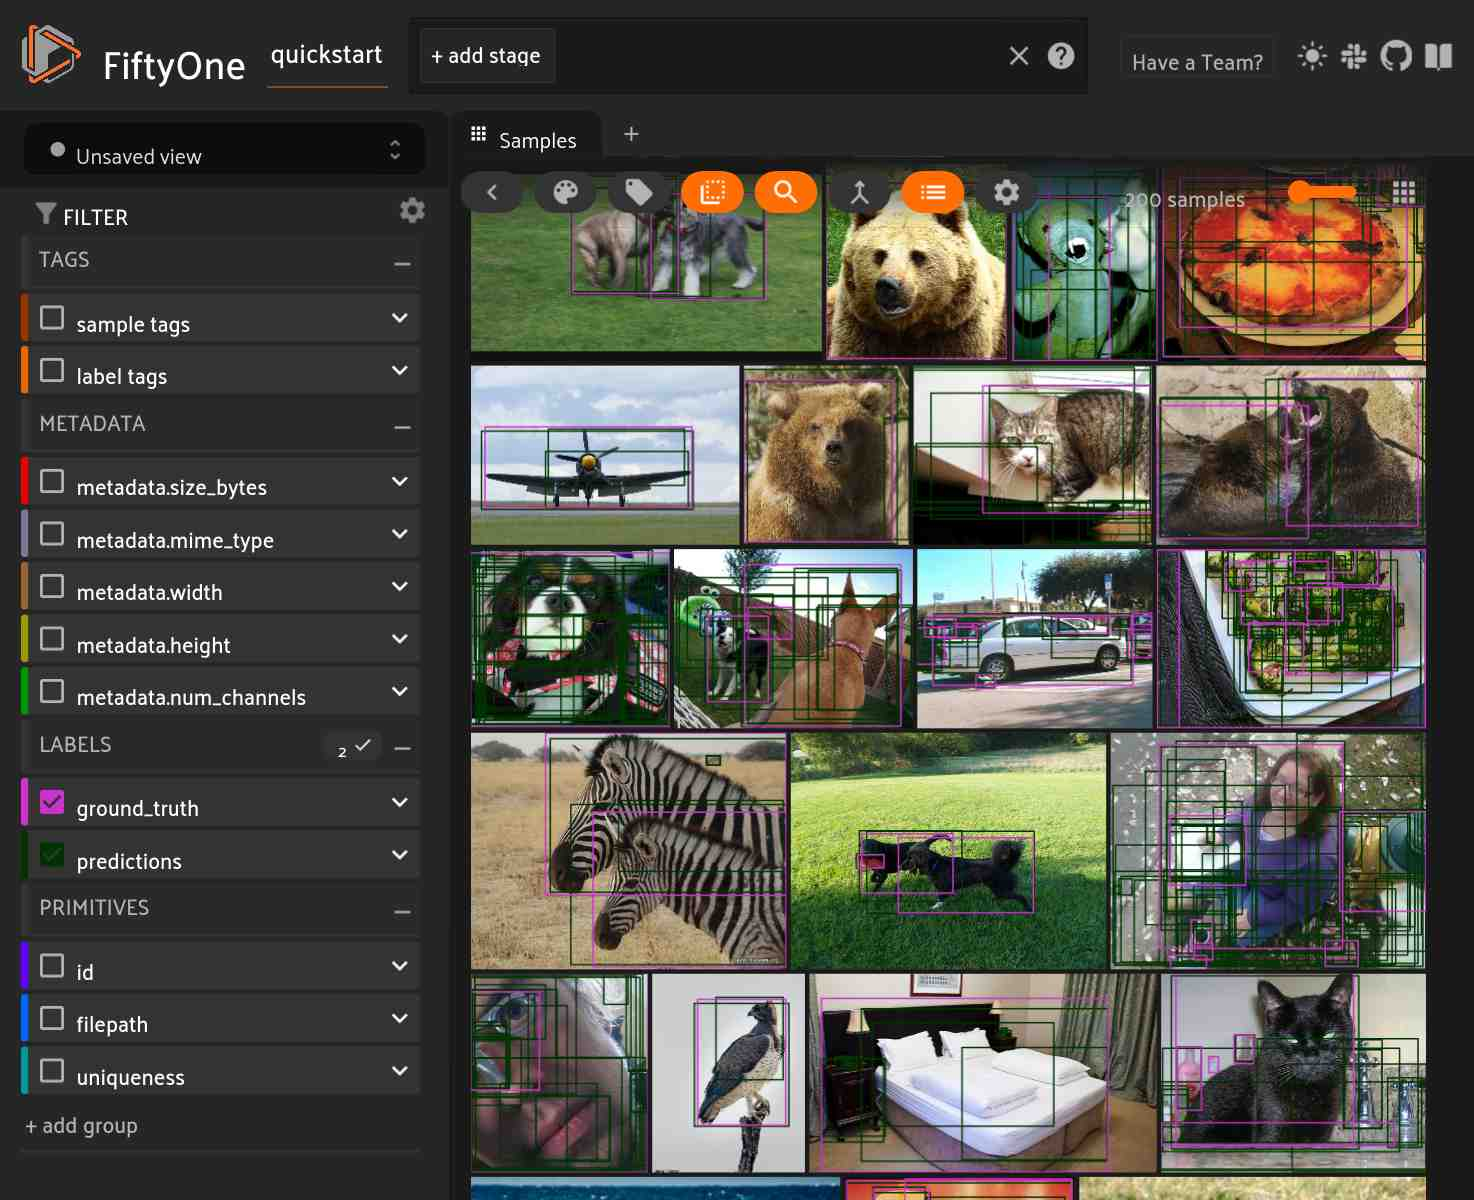


Could not connect session, trying again in 10 seconds



In [19]:
import os
import numpy as np
import fiftyone as fo
import fiftyone.zoo as foz


dataset = foz.load_zoo_dataset("quickstart")
session = fo.launch_app(dataset)

In [24]:
dataset.compute_metadata()

for sample in dataset:
    filepath = sample.filepath
    base_name = os.path.basename(filepath)
    name, extension = os.path.splitext(base_name) 
    #print("./SWAHR-HumanPose/output_quick/" + name + "_heatmap.png")
    heatmap = fo.Heatmap(map_path="/path/to/SWAHR-HumanPose/output_quick/" + name + "_heatmap.png")

    sample["heatmap"] = heatmap
    sample.save()

session = fo.launch_app(dataset)

### FiftyOne Heatmap Example Output

![Sample Image](heatmaps/heatmap.png)

### Model Output

![Out Image](heatmaps/heat_out.png)